# Pruebas VotingClassifier: Adaboost + GradientBoost + RandomForest

El set de training usado se genera desde `lucho/generar_set_test`

Entrena:
- Adaboost en la misma forma que en submit-41 (Adaboost/DecisionTree)
- Adaboost en la misma forma que en submit-40 (Adaboost/RandomForest)
- GradientBoost en la misma forma que en submit-39
- RandomForest en la misma forma que en submit-36

Cada estimador tiene asignado como peso el score obtenido en kaggle

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [2]:
RANDOM_SEED = 12

In [3]:
entrenamiento = pd.read_csv('/home/luciano/orga-datos/training-set-final.csv')

In [4]:
no_postulaciones = entrenamiento[entrenamiento['sepostulo'] == 0].sample(500000, random_state=RANDOM_SEED)
postulaciones    = entrenamiento[entrenamiento['sepostulo'] == 1]

entrenamiento = pd.concat([postulaciones, no_postulaciones]).sample(frac=1)

In [5]:
kaggle_set = pd.read_csv('/home/luciano/orga-datos/test_final_100k-preprocesado.csv')

In [6]:
TEST_SIZE_PERCENT = 0.1

In [7]:
X = entrenamiento.drop(axis=1, labels=['idaviso', 'idpostulante', 'sepostulo'])
y = entrenamiento['sepostulo']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PERCENT, random_state=RANDOM_SEED)

In [8]:
X_kaggle = kaggle_set.drop(axis=1, labels=['id', 'idaviso', 'idpostulante'])

In [10]:
adaboost_1 = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(
        min_samples_split=100, 
        random_state=RANDOM_SEED
    ),
    n_estimators=50,
    random_state=RANDOM_SEED
)

adaboost_2 = AdaBoostClassifier(
    base_estimator = RandomForestClassifier(
        n_estimators=16, 
        criterion='entropy', 
        max_features='sqrt', 
        min_samples_split=100, 
        n_jobs=-1, 
        random_state=RANDOM_SEED, 
    ),
    n_estimators=15,
    random_state=RANDOM_SEED
)

gradientboost = GradientBoostingClassifier(
    max_features='sqrt', 
    min_samples_split=100, 
    random_state=RANDOM_SEED, 
)

randomforest = RandomForestClassifier(
    n_estimators=10, 
    criterion='entropy', 
    max_features='sqrt', 
    min_samples_split=100, 
    n_jobs=-1, 
    random_state=RANDOM_SEED, 
)

clasificador = VotingClassifier(
    [adaboost_1, adaboost_2, gradientboost, randomforest], 
    voting='hard', 
    weights=[0.93523, 0.93422, 0.88467, 0.88869], 
    n_jobs=-1
)

In [12]:
adaboost_1.fit(X_train, y_train)
adaboost_2.fit(X_train, y_train)

In [13]:
gradientboost.fit(X_train, y_train)
randomforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [19]:
estimadores = [adaboost_1, adaboost_2, gradientboost, randomforest]

In [31]:
def predecir(X):
    y_pred = None
    pesos = [0.93523, 0.93422, 0.88467, 0.88869]
    for estimador, peso in zip(estimadores, pesos):
        if y_pred is None:
            y_pred = estimador.predict_proba(X)[:, 1] * peso
        else:
            y_pred += estimador.predict_proba(X)[:, 1] * peso

    return y_pred / sum(pesos)

In [32]:
y_test_predictd = predecir(X_test)

In [33]:
roc_auc_score(y_test, y_test_predictd)

0.9923314699730351

In [34]:
y_kaggle = predecir(X_kaggle)

In [36]:
kaggle_out = kaggle_set[['id']].copy()
kaggle_out['sepostulo'] = y_kaggle

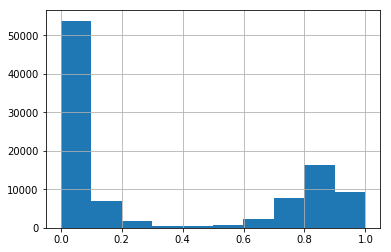

In [37]:
kaggle_out['sepostulo'].hist()

In [42]:
SUBMIT_FILE = '/home/luciano/orga-datos/tmp/submits/submit-42.csv'
import os
assert not os.path.exists(SUBMIT_FILE), "Cambiar el número de submit!!"
kaggle_out.to_csv(SUBMIT_FILE, index=False)

AssertionError: Cambiar el número de submit!!

In [43]:
kaggle_38 = pd.read_csv('/home/luciano/orga-datos/tmp/submits/submit-38.csv')

In [45]:
print('ROCAUC 38 vs actual:', roc_auc_score(np.round(kaggle_38['sepostulo']), kaggle_out['sepostulo']))

ROCAUC 38 vs actual: 0.998721606050554


In [46]:
np.abs(kaggle_38['sepostulo'] - kaggle_out['sepostulo']).hist()

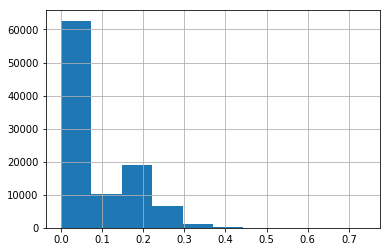

In [46]:
# Score kaggle: 0.91